In [1]:
import os
os.chdir("../")

In [2]:
import warnings
import numpy as np
import jax.numpy as jnp
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
font_path = "/home/nanxi/.local/share/fonts/Palatino-Linotype-Regular.ttf"
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    prop = matplotlib.font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Set font to {prop.get_name()}")

Set font to Palatino Linotype


In [3]:
# load mat data
from scipy.io import loadmat
from scipy import signal
data = loadmat("./data/high_rise_building_wind.mat")
wind_data = data["windsp_1h"].flatten()
fs = 1
decimation_factor = int(100 / fs)  # 原始采样率100Hz，目标采样率2Hz
wind_data = signal.decimate(wind_data, decimation_factor, ftype='iir')

wind_data.shape

(3600,)

In [4]:
frequencies, psd = signal.welch(wind_data-np.mean(wind_data), fs=fs,
                                window='hamming', 
                                scaling='density', nperseg=1024)
frequencies = frequencies[1:]  # 去掉直流分量
psd = psd[1:]
u_bar = np.mean(wind_data)
u10 = u_bar * (10 / 450) ** 0.30
z = 632
z0 = 1.0
H_ = 100
K = 0.4
zd = H_ - z0 / K
u_star = K * u_bar / np.log((z - zd) / z0)
f = frequencies * z / u_bar
reference_psd = 200 * f / (1 + 50 * f)**(5/3) * u_star**2 / frequencies

In [5]:
from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="jax", key=42, spectrum_type="kaimal-nd")
simulator.update_parameters(
    H_bar=H_,
    z_0=z0,
    T=3600,
    M=3600,
    dt=1,
    U_d=u10,
    alpha_0=0.30,
    w_up=0.5,
)

n = 50
Z = 632
position = np.zeros((n, 3))
position[:, 2] = np.linspace(200, Z, n)
position[:, 0] = 0
position[:, 1] = 0
wind_speeds = u10 * (jnp.minimum(position[:, 2], 450) / 10) ** 0.30
samples, frequencies_sim = simulator.simulate_wind(
    position, wind_speeds, component="u"
)
frequencies_sim, psd_sim = signal.welch(samples[-1], fs=1, window='hamming', 
                                   scaling='density', nperseg=1024)

In [6]:
wind_speeds

Array([14.29912 , 14.485371, 14.666197, 14.841965, 15.013006, 15.179617,
       15.342067, 15.5006  , 15.655437, 15.806782, 15.954819, 16.099718,
       16.241638, 16.38072 , 16.517101, 16.650904, 16.782244, 16.911228,
       17.037956, 17.162521, 17.285015, 17.405514, 17.524097, 17.640837,
       17.755804, 17.869057, 17.980661, 18.090672, 18.199142, 18.237448,
       18.237448, 18.237448, 18.237448, 18.237448, 18.237448, 18.237448,
       18.237448, 18.237448, 18.237448, 18.237448, 18.237448, 18.237448,
       18.237448, 18.237448, 18.237448, 18.237448, 18.237448, 18.237448,
       18.237448, 18.237448], dtype=float32)

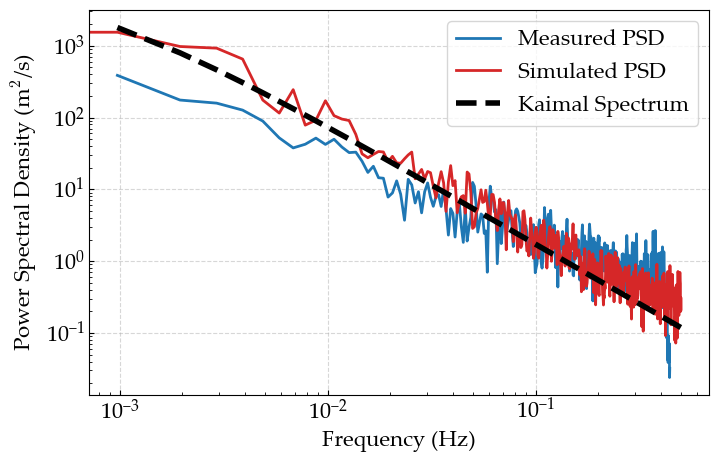

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies[:-60], psd[:-60], label="Measured PSD", color="C0", lw=2)
ax.loglog(frequencies_sim, psd_sim, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies, reference_psd, label="Kaimal Spectrum", color="black", linestyle="--", lw=4)
ax.legend()
ax.set(xlabel="Frequency (Hz)", ylabel="Power Spectral Density (m$^2$/s)")
fig.savefig("./img/high_rise_building_wind_spectrum.pdf", bbox_inches="tight")
fig.savefig("./img/high_rise_building_wind_spectrum.png", bbox_inches="tight", dpi=300)